In [1]:
import warnings
warnings.filterwarnings('ignore')

# Narrative Alignment Analysis

H. Priniski contact at last name at ucla dot edu. 

This Jupyter notebook reproduces the analyses of the human experiment in the following publication: 

Priniski, J.H., Linford, B., Cao, D., Morstatter, F., Brantingham, J., & Lu, H. (2025). Effect-prompting shifts the narrative framing of networked interactions. Proceedings of the Cognitive Science Society.

## 🧠 Research Question

**Can a simple linguistic prompt shift the way groups frame narratives during online interaction?**  
Specifically, does asking individuals to list the *effects* of a disaster before networked communication change the kinds of hashtags they use and how groups converge on shared narratives?

---

## 🧪 Methodology

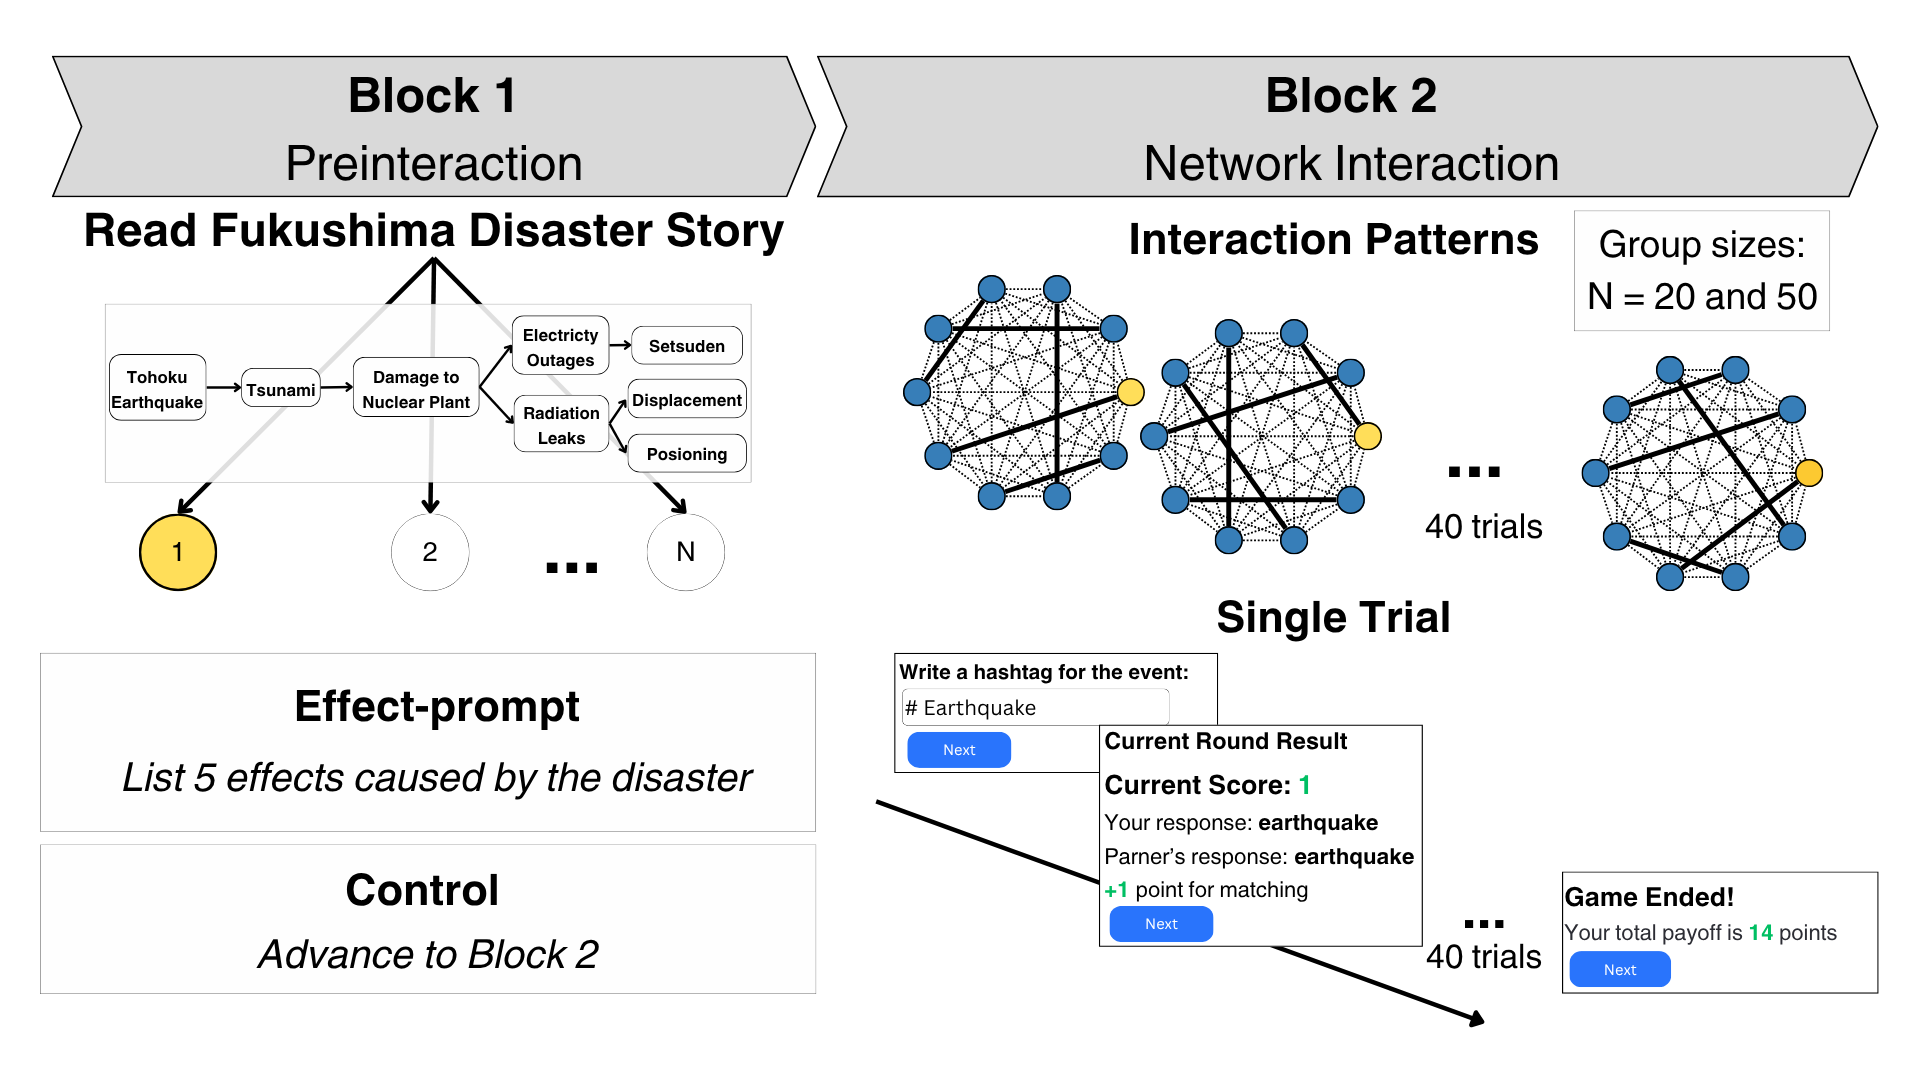

- **Participants:** 420 humans in fully-connected online networks (N = 20 or N = 50), randomly assigned to a control or *effect-prompting* condition.
- **Intervention:** Half the participants were asked to list five effects of the Fukushima nuclear disaster before submitting hashtags during a 40-round networked coordination task.
- **Task:** In each round, participants generated a hashtag and received rewards for matching hashtags with network neighbors.
- **Metrics:**
  - *Entropy* of group hashtag distributions (to measure coherence) (Not shown in notebook).
  - *Narrative alignment* using cosine similarity between hashtags and causal events in the narrative

---

## 🔍 Key Findings

- **Effect-Prompting Works:** Participants exposed to the prompt generated more hashtags reflecting *effects* of the disaster (e.g., #EnergyCrisis), rather than generic or cause-based topics (e.g., #Earthquake).
- **Coherence Tradeoff:** Effect-prompted groups were slower to converge on a shared hashtag, especially in larger networks.
- **Coordination Depends on Narrative Framing:** Hashtags aligned with broad *topics* were more likely to match across participants than those targeting specific narrative effects.
- **LLMs Struggle Without Narrative Context:** LLM networks showed no coherence emergence without direct narrative framing in prompts, and only minor shifts in hashtag content.



# Analysis Code

Load prerequiste pacakges. 

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from scipy.special import softmax

## 📏 Narrative Alignment Measure

To quantify how closely participant-generated hashtags aligned with the narrative’s causal structure, we developed a **narrative alignment measure** based on semantic similarity.

The original narrative particiapnts interactive over was segmented into **discrete causal events** (e.g., Earthquake → Tsunami → Radiation Leaks → Energy Movement).

We used the **`all-MiniLM-L6-v2` SentenceTransformer** to embed both:
- Each causal event segment from the narrative
- Each participant-generated hashtag

For each hashtag, we computed **cosine similarity** to all event embeddings. We then compute a softmax across the similarities to each of the narrative entities to normalize alignment vectors to sum to 1. **Narrative alignment measures therefore proxy a form of narrative credence, where language is mapped to narrative components as a function of their semantic alignment.**

The hashtag alignment vectors allows us to analyze:
- Which parts of the narrative participants referenced most
 - How interventions (e.g., effect-prompting) shifted focus toward different causal events

This method provided a fine-grained, interpretable way to track **narrative focus over time** during group communication.

In [172]:
#softmax(x) = np.exp(x)/sum(np.exp(x)) . That is, if x is a one-dimensional numpy array:

def softmax_with_temperature(x, tau=1.0):
    scaled_x = x / tau
    return softmax(scaled_x)
    
def compute_narrative_alignment(df, responses, model, narrative_segments, tau = 1):

    segment_embeddings = model.encode(narrative_segments, convert_to_tensor=True)
    
    hashtag_embeddings = model.encode(responses, convert_to_tensor=True)
    similarity_scores = util.cos_sim(hashtag_embeddings, segment_embeddings)

    results = []
    
    for i, hashtag in enumerate(responses):
        row_data = df.iloc[i]
        row_similarities = similarity_scores[i].cpu().numpy()
        softmax_scores = softmax_with_temperature(row_similarities, tau=tau) 

       
        most_similar_idx = similarity_scores[i].argmax().item()  # Find the most similar segment
        similarity_score = similarity_scores[i][most_similar_idx].item()
        results.append({
            "Run": row_data['Run'],
            "Round": row_data["TrialNumber"],
            "Player": row_data["random ID"],
            "Condition": row_data['Condition'],
            'Size': row_data['Size'],
            "Hashtag": hashtag,
            "Narr. Loading": row_similarities,
            "Narr. Loading (Normed)": softmax_scores,
            "Most Similar Segment": narrative_segments[most_similar_idx],
            "Segment Index": most_similar_idx,
            "Similarity Score": similarity_score
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df

In [7]:
# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Narrative split into segments (manually or by sentence splitting). Here, I chunk by causal event to allow for causal alignment of narrative interactions. 
narrative_segments = [
    "The Fukushima Nuclear Disaster was a 2011 nuclear accident at the Daiichi Nuclear Power Plant in Fukushima, Japan.",
    "The cause was the Tōhoku earthquake on March 11, 2011, the most powerful earthquake ever recorded in Japan.", #removed 'of the nuclear disaster'
    "It triggered a tsunami with waves up to 130 feet tall, with 45-foot tall waves causing direct damage.", #removed nuclear power plant
    "The damage caused Japanese authorities quickly implemented a 100-foot exclusion zone.", #removed  around the power plant, and radioactive isotopes in reactor coolant to discharge into the sea, therefore 
    "Large quantities of radioactive particles were found shortly after throughout the Pacific Ocean and reached the California coast.",
    "Resulting energy shortage inspired media campaigns to encouraged households and businesses to cut back on electrical usage",
    "Which led to the national movement Setsuden (saving electricity).",
    "The exclusion zone resulted in the displacement of approximately 156,000 people in years to follow.",
    "Independent commissions continue to recognize that affected residents are still struggling and facing grave concerns. A World Health Organization (WHO) report predicts that infant girls exposed to the radiation are 70% more likely to develop thyroid cancer.",
]

In [4]:
#Read in the human data
humans1 = pd.read_csv('all_results_df.csv')

In [5]:
#Each unique network run
humans1['Run'].unique()

array(['1en', '2en', '3en', '1nn', '2nn', '3nn'], dtype=object)

In [173]:
#Align the human generated hashtags with the focal narr
humans_aligned = compute_narrative_alignment(humans1, humans1['Response'], model, narrative_segments, tau = .2)

In [174]:
#Rename the condition variables for clearer figures.
humans_aligned['Condition'] = humans_aligned['Condition'].replace('Experimental', 'Effect-prompted')
humans_aligned

,Run,Round,Player,Condition,Size,Hashtag,Narr. Loading,Narr. Loading (Normed),Most Similar Segment,Segment Index,Similarity Score
0,1en,1,17013,Effect-prompted,20,fukushima,"[0.65759397, 0.35879093, 0.2978896, 0.2845905,...","[0.44469288, 0.09982001, 0.073615976, 0.068880...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.657594
1,1en,1,97413,Effect-prompted,20,dihatsudesaster,"[0.11758068, 0.06048458, 0.14230295, -0.024671...","[0.13851583, 0.10411584, 0.15674119, 0.0680147...",It triggered a tsunami with waves up to 130 fe...,2,0.142303
2,1en,1,56281,Effect-prompted,20,nuclear,"[0.41579908, 0.20580392, 0.22280884, 0.1452126...","[0.26071313, 0.09123557, 0.09933216, 0.0673894...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.415799
3,1en,1,83720,Effect-prompted,20,nucleardisaster,"[0.37946498, 0.15419897, 0.14520296, 0.0653105...","[0.28251892, 0.09159854, 0.08756972, 0.0587313...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.379465
4,1en,1,91363,Effect-prompted,20,nuclearwaste,"[0.35429823, 0.15787117, 0.13727225, 0.1303222...","[0.25568599, 0.095757104, 0.086385526, 0.08343...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.354298
...,...,...,...,...,...,...,...,...,...,...,...
15536,3nn,40,74104,Control,50,nucleardisaster,"[0.37946498, 0.15419897, 0.14520296, 0.0653105...","[0.28251892, 0.09159854, 0.08756972, 0.0587313...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.379465
15537,3nn,40,45494,Control,50,nucleardisaster,"[0.37946498, 0.15419897, 0.14520296, 0.0653105...","[0.28251892, 0.09159854, 0.08756972, 0.0587313...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.379465
15538,3nn,40,94841,Control,50,nucleardisaster,"[0.37946498, 0.15419897, 0.14520296, 0.0653105...","[0.28251892, 0.09159854, 0.08756972, 0.0587313...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.379465
15539,3nn,40,39100,Control,50,nucleardisaster,"[0.37946498, 0.15419897, 0.14520296, 0.0653105...","[0.28251892, 0.09159854, 0.08756972, 0.0587313...",The Fukushima Nuclear Disaster was a 2011 nucl...,0,0.379465


## 📊 Visualizing Narrative Focus Across Experimental Conditions

This analysis compares how participants in different conditions (Control vs. Effect-prompted) and network sizes (20 vs. 50) focused on different parts of the narrative's causal structure.

- Each hashtag is semantically matched to a **narrative entity** (e.g., Topic, Cause, Effect).
- Softmax-normalized scores indicate the degree of alignment between a participant’s responses and each narrative group.
- The code:
  1. Maps narrative entity indices to conceptual groups (e.g., Causes, Effects).
  2. Reshapes the data to long format for group-based analysis.
  3. Aggregates softmax scores by participant, group, condition, and network size.
  4. Computes mean and standard error across players.
  5. Plots group-level focus on each narrative segment, showing differences across experimental conditions and sizes.
  6. Adds *asterisks* to indicate statistically significant differences between Control and Effect-prompted conditions using t-tests.

### 💡 This plot and significance tests reveal how effect-prompting shifts narrative attention from general topics toward later-stage effects in the narrative. 


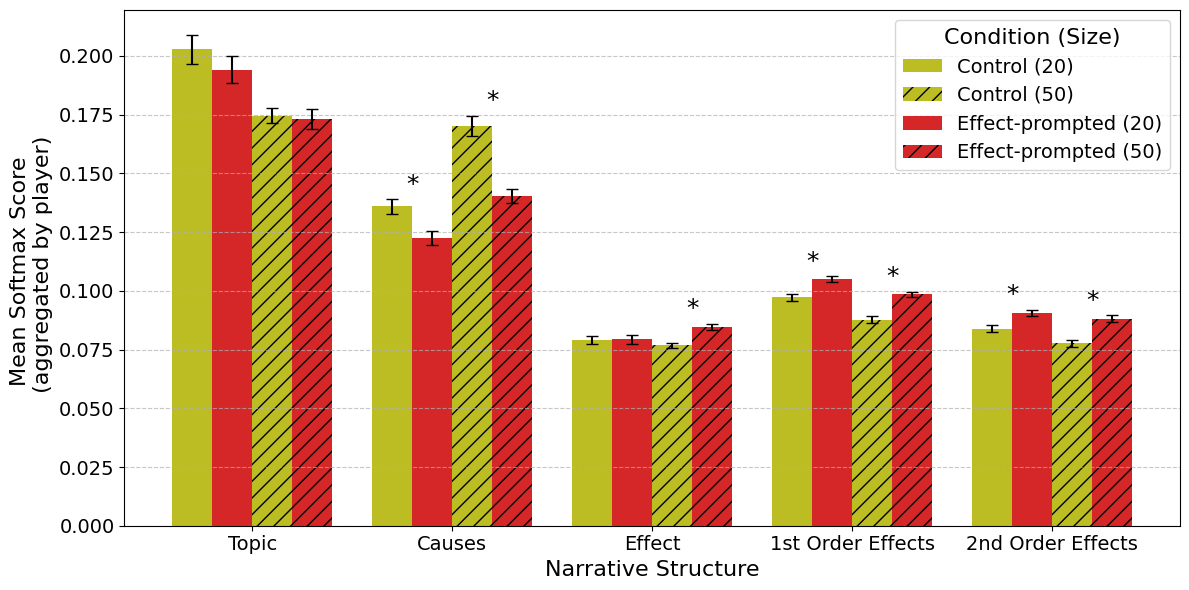

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind

# Step 1: Mapping of indices to semantic groups
group_map = {
    0: "Topic",
    1: "Causes",
    2: "Causes",
    3: "Effect",
    4: "1st Order Effects",
    5: "1st Order Effects",
    6: "2nd Order Effects",
    7: "2nd Order Effects",
    8: "2nd Order Effects"
}

group_labels = ["Topic", "Causes", "Effect", "1st Order Effects", "2nd Order Effects"]

# Step 2: Expand to long format
long_rows = []
for _, row in humans_aligned.iterrows():
    player = row["Player"]
    condition = row["Condition"]
    size = row["Size"]
    loading = row["Narr. Loading (Normed)"]
    for idx, score in enumerate(loading):
        group_label = group_map.get(idx)
        long_rows.append({
            "Player": player,
            "Condition": condition,
            "Size": size,
            "Group": group_label,
            "Softmax Score": score
        })

long_df = pd.DataFrame(long_rows)

# Step 3: Aggregate by Player × Condition × Size × Group
agg_df = long_df.groupby(["Player", "Condition", "Size", "Group"])["Softmax Score"].mean().reset_index()

# Step 4: Compute mean and SEM across players
summary_df = agg_df.groupby(["Condition", "Size", "Group"])["Softmax Score"].agg(['mean', sem]).reset_index()

# Step 5: Plot setup
conditions = ['Control', 'Effect-prompted']
sizes = [20, 50]
bar_width = 0.2
x = np.arange(len(group_labels))

colors = {
    'Control': '#bcbd22',
    'Effect-prompted': '#d62728'
}
hatches = {
    20: '',
    50: '//'
}
offsets = {
    ('Control', 20): -1.5 * bar_width,
    ('Effect-prompted', 20): -0.5 * bar_width,
    ('Control', 50): 0.5 * bar_width,
    ('Effect-prompted', 50): 1.5 * bar_width
}

# Step 6: Statistical testing
significance_annotations = {}  # {(size, group_label): True/False}

for size in sizes:
    for label in group_labels:
        group_data = agg_df[(agg_df["Size"] == size) & (agg_df["Group"] == label)]
        control_scores = group_data[group_data["Condition"] == "Control"]["Softmax Score"]
        experimental_scores = group_data[group_data["Condition"] == "Effect-prompted"]["Softmax Score"]
        if len(control_scores) > 1 and len(experimental_scores) > 1:
            t_stat, p_val = ttest_ind(control_scores, experimental_scores, equal_var=False)
            significance_annotations[(size, label)] = p_val < 0.05

# Step 7: Plot
fig, ax = plt.subplots(figsize=(12, 6))

for cond in conditions:
    for size in sizes:
        subset = summary_df[(summary_df["Condition"] == cond) & (summary_df["Size"] == size)]
        means = []
        errors = []
        for label in group_labels:
            row = subset[subset["Group"] == label]
            means.append(row["mean"].values[0] if not row.empty else 0)
            errors.append(row["sem"].values[0] if not row.empty else 0)

        offset = offsets[(cond, size)]
        ax.bar(
            x + offset,
            means,
            yerr=errors,
            width=bar_width,
            capsize=4,
            label=f"{cond} ({size})",
            color=colors[cond],
            hatch=hatches[size]
        )

# Step 8: Add significance asterisks
for i, label in enumerate(group_labels):
    for size in sizes:
        if significance_annotations.get((size, label), False):
            x_center = x[i] + (offsets[('Control', size)] + offsets[('Effect-prompted', size)]) / 2
            subset = summary_df[(summary_df["Size"] == size) & (summary_df["Group"] == label)]
            y_max = subset["mean"].values.max() + subset["sem"].values.max()
            ax.text(
                x_center,
                y_max + 0.001,
                "*",
                ha='center',
                va='bottom',
                fontsize=18,
                color='black'
            )

# Final formatting
ax.set_xticks(x)
ax.set_xticklabels(group_labels, fontsize=14)
ax.set_xlabel("Narrative Structure", fontsize=16)
ax.set_ylabel("Mean Softmax Score \n (aggregated by player)", fontsize=16)
ax.legend(title="Condition (Size)", fontsize=14, title_fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.show()
